In [13]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim


In [14]:
# Image loading and processing function
def load_and_process_image(image_path):
    # Read the image from the path
    image_string = tf.io.read_file(image_path)
    # Decode image to float32 tensor
    image = tf.image.decode_jpeg(image_string, channels=3)
    # Normalize pixel values to [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Add batch dimension
    image = tf.expand_dims(image, 0)
    return 0.5 * image  # Optionally scale down

# Example Usage
image_path = r"C:\Users\ASUS\Documents\DIP\images\images1.jpg"
I0 = load_and_process_image(image_path)
I = load_and_process_image(image_path)


In [15]:
def initialize_with_kmeans(image_pixels, k=2):
    kmeans = KMeans(n_clusters=k).fit(image_pixels)
    centers = kmeans.cluster_centers_
    return centers

def maximization_step(image_pixels, assignments, noise_std):
    primary_pixels = image_pixels[assignments == 0]
    secondary_pixels = image_pixels[assignments == 1]

    primary_color = np.mean(primary_pixels, axis=0)
    secondary_color = np.mean(secondary_pixels, axis=0)

    #Calculate standard deviation with the noise constraint
    primary_std = np.clip(np.std(primary_pixels, axis=0), noise_std, None)
    secondary_std = np.clip(np.std(secondary_pixels, axis=0), noise_std, None)
    return primary_color, secondary_color, primary_std, secondary_std

def expectation_step(image_pixels, primary_color, secondary_color, primary_std, secondary_std):
    primary_gaussian = multivariate_normal(mean=primary_color, cov=primary_std)
    secondary_gaussian = multivariate_normal(mean=secondary_color, cov=secondary_std)

    primary_probs = primary_gaussian.pdf(image_pixels)
    secondary_probs = secondary_gaussian.pdf(image_pixels)
    
    assignments = np.where(primary_probs > secondary_probs, 1, 0)
    return assignments


In [16]:
def two_color_gmm(image_tensor, noise_std, num_iterations=10):
    image_pixels = image_tensor.numpy().reshape(-1, image_tensor.shape[-1])
    primary_color, secondary_color = initialize_with_kmeans(image_pixels)
    primary_std = secondary_std = np.std(image_pixels, axis=0)

    for _ in range(num_iterations):
        assignments = expectation_step(image_pixels, primary_color, secondary_color, primary_std, secondary_std)
        primary_color, secondary_color, primary_std, secondary_std = maximization_step(
            image_pixels, assignments, noise_std
        )

    P = np.zeros_like(image_tensor)
    S = np.zeros_like(image_tensor)
    assignments_reshaped = assignments.reshape(image_tensor.shape[:-1])
    P[assignments_reshaped == 1] = image_tensor[assignments_reshaped == 1]
    S[assignments_reshaped == 0] = image_tensor[assignments_reshaped == 0]
    return P, S

# Example usage
P, S = two_color_gmm(I, noise_std=0.05)


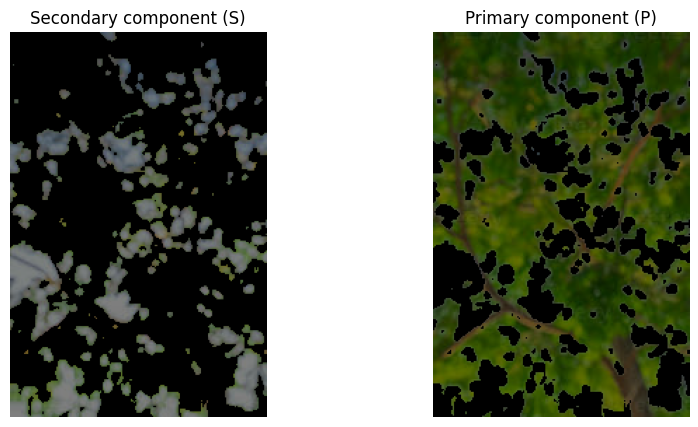

In [17]:
# Convert from tensor to numpy if necessary.
S_plot = tf.squeeze(S).numpy()
P_plot = tf.squeeze(P).numpy()  # Convert from tensor to numpy if necessary.

# Tracing the images
plt.figure(figsize=(10, 5))

# Tracing the original image I
plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
plt.imshow(S_plot)
plt.title('Secondary component (S)')
plt.axis('off')  # Hide axes

# Plot the calculated matrix P
plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
plt.imshow(P_plot)
plt.title('Primary component (P)')
plt.axis('off')  # Hide axes

# Display frames
plt.show()

In [18]:
@tf.function
def compute_alpha(I, P, S):
    numerator = (P - S) * (I - S)
    denominator = tf.square(P - S) + 0.001  # Add stability term
    alpha = numerator / denominator
    return alpha

@tf.function
def update_I(I, P, S, lambda_1, lambda_2, lambda_3):
    with tf.GradientTape() as tape:
        tape.watch(I)
        alpha = compute_alpha(I, P, S)
        L2_norm = tf.reduce_mean(tf.square(I - alpha * P + (1 - alpha) * S))
        rho_alpha = tf.reduce_mean(tf.square((I - S) / (tf.reduce_sum(tf.square(P - S), axis=-1, keepdims=True) + 1e-2)))
        grad_I = tf.image.sobel_edges(I)
        grad_norm = tf.reduce_mean(tf.square(tf.norm(grad_I, axis=-1)))
        loss = lambda_1 * L2_norm + lambda_2 * rho_alpha - lambda_3 * grad_norm
    derivative = tape.gradient(loss, I)
    I_updated = I - 0.1 * derivative
    return I_updated


In [19]:
def irls(I, P, S, lambda_1, lambda_2, lambda_3, tolerance, max_iterations):
    for iteration in range(max_iterations):
        I_prev = I
        I = update_I(I, P, S, lambda_1, lambda_2, lambda_3)
        if tf.reduce_max(tf.abs(I - I_prev)) < tolerance:
            break
    return I

In [20]:
def plot_results(I_optimized, I0, P, S):
    # Ensure alpha is computed inside the function
    alpha = compute_alpha(I_optimized, P, S)
    reconstructed = tf.squeeze(alpha * P + (1 - alpha) * S).numpy()  # Reconstructed image
    original = tf.squeeze(I0).numpy()  # Original image

    plt.figure(figsize=(20, 10))

    # Plot the original image on the left
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
    plt.imshow(original)
    plt.title('Original Image')
    plt.axis('off')

    # Plot the reconstructed image on the right
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
    plt.imshow(reconstructed)
    plt.title('Reconstructed Image')
    plt.axis('off')

    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.083845295..0.6396644].


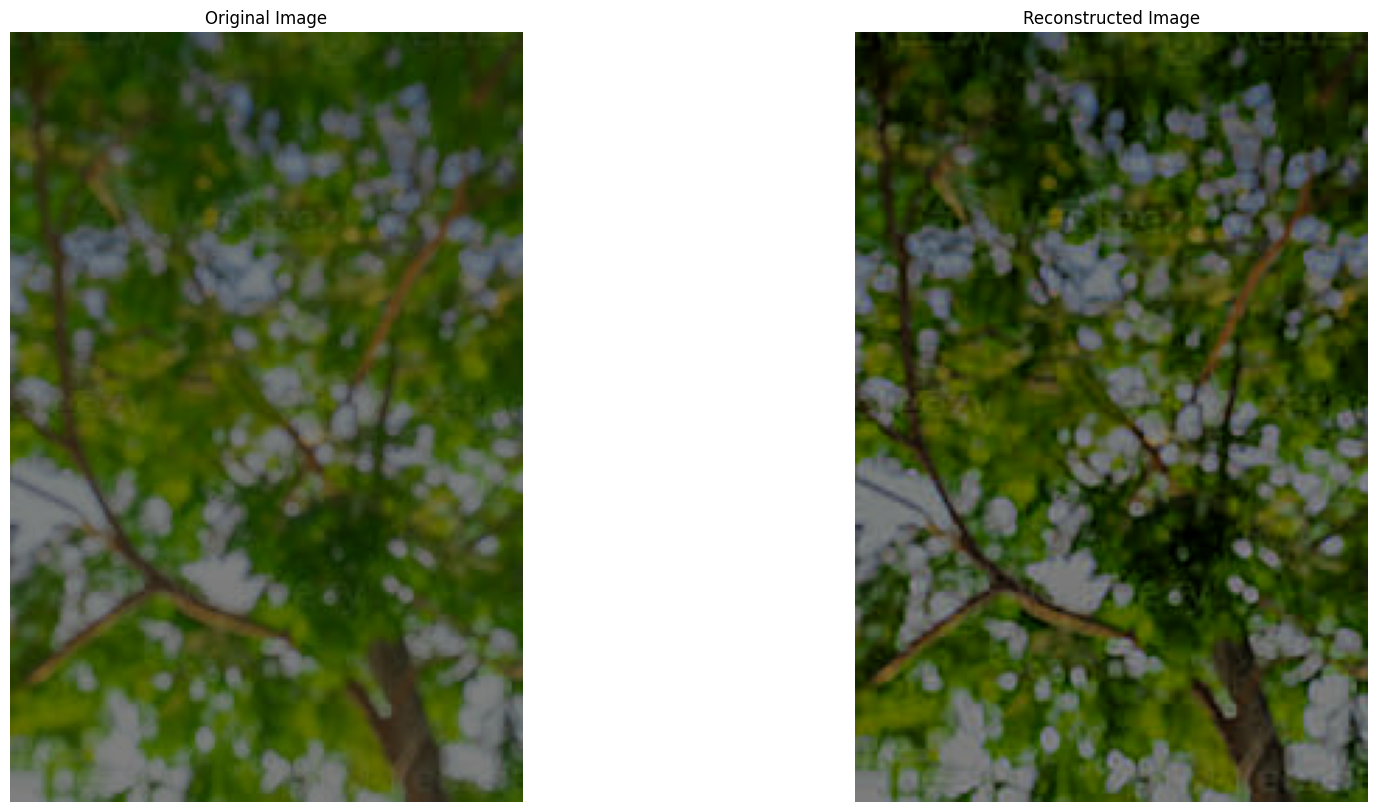

In [21]:
# Example usage
image_path = r"C:\Users\ASUS\Documents\DIP\images\images1.jpg"
I0 = load_and_process_image(image_path)
I = load_and_process_image(image_path)

lambda_1 = 0.5
lambda_2 = 0.2
lambda_3 = 1.0
tolerance = 1e-8
max_iterations = 10000

I_optimized = irls(I, P, S, lambda_1, lambda_2, lambda_3, tolerance, max_iterations)
plot_results(I_optimized, I0, P, S)
